In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import keras
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())
import numpy as np
import pandas as pd
from collections import defaultdict
import re


import sys
import os

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout
from tensorflow.keras.layers import *
from keras.models import Model

MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 200000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17483428263977254350
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 11019092236459016821
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 13561510963610684466
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15695549568
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2078102391869108571
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


In [ ]:
data_train = pd.read_csv('/content/gdrive/MyDrive/new/TanKianLong_1181300023/dataset/D1.csv')

In [ ]:
data_train.head()

,Unnamed: 0,id,title,text,label
0,0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",1
1,1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,1
2,2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,0
3,3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",1
4,4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,0


In [ ]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6335 non-null   int64 
 1   id          6335 non-null   int64 
 2   title       6335 non-null   object
 3   text        6335 non-null   object
 4   label       6335 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 247.6+ KB


In [ ]:
# Convert to lowercase

data_train['text'] = data_train['text'].apply(lambda x: x.lower())
data_train.head()

,Unnamed: 0,id,title,text,label
0,0,8476,You Can Smell Hillary’s Fear,"daniel greenfield, a shillman journalism fello...",1
1,1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,google pinterest digg linkedin reddit stumbleu...,1
2,2,3608,Kerry to go to Paris in gesture of sympathy,u.s. secretary of state john f. kerry said mon...,0
3,3,10142,Bernie supporters on Twitter erupt in anger ag...,"— kaydee king (@kaydeeking) november 9, 2016 t...",1
4,4,875,The Battle of New York: Why This Primary Matters,it's primary day in new york and front-runners...,0


In [ ]:
# Remove punctuation

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data_train['text'] = data_train['text'].apply(punctuation_removal)

In [ ]:
# Removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english','arabic')
stop.extend(["said", "reuters", "CNN", "would", "image", "via"])

data_train['text'] = data_train['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
data_train.head()

,Unnamed: 0,id,title,text,label
0,0,8476,You Can Smell Hillary’s Fear,daniel greenfield shillman journalism fellow f...,1
1,1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,google pinterest digg linkedin reddit stumbleu...,1
2,2,3608,Kerry to go to Paris in gesture of sympathy,us secretary state john f kerry monday stop pa...,0
3,3,10142,Bernie supporters on Twitter erupt in anger ag...,— kaydee king kaydeeking november 9 2016 lesso...,1
4,4,875,The Battle of New York: Why This Primary Matters,primary day new york frontrunners hillary clin...,0


In [ ]:
def clean_str(string):
    """
    Cleaning of dataset
    """
    string = re.sub(r"\\", "", string)    
    string = re.sub(r"\'", "", string)    
    string = re.sub(r"\"", "", string)    
    return string.strip().lower()

In [ ]:
#print('What the raw input data looks like:')
#print(data_train[0:5])
texts = []
labels = []

for i in range(data_train.text.shape[0]):
    text2 = data_train.text[i]
    text = str(text2)
    texts.append(text)
    labels.append(data_train.label[i])
    
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 110125 unique tokens.


In [ ]:
# Pad input sequences
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(labels),num_classes = 2)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (6335, 1000)
Shape of label tensor: (6335, 2)


In [ ]:
# Train test validation Split
from sklearn.model_selection import train_test_split

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
x_train, x_test, y_train, y_test = train_test_split( data, labels, test_size=0.20, random_state=42)
x_test, x_val, y_test, y_val = train_test_split( x_test, y_test, test_size=0.50, random_state=42)
print('Size of train, validation, test:', len(y_train), len(y_val), len(y_test))

print('real & fake news in train,valt,test:')
print(y_train.sum(axis=0))
print(y_val.sum(axis=0))
print(y_test.sum(axis=0))

Size of train, validation, test: 5068 634 633
real & fake news in train,valt,test:
[2532. 2536.]
[303. 331.]
[336. 297.]


In [ ]:
from keras.models import Sequential
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
import numpy as np
from matplotlib import pyplot as plt
from keras.layers import Dense, Embedding, LSTM, GRU

%matplotlib inline

In [ ]:
GLOVE_DIR = "data" 
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, '/content/gdrive/My Drive/FYP/report/ALL/LSTM/glove.6B.100d.txt'), encoding="utf8") #The file that you had downloaded and moved from local session to drive.

In [ ]:
for line in f:
    values = line.split()
    #print(values[1:])
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove.' % len(embeddings_index))

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH)


Total 400000 word vectors in Glove.


In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers

 LSTM

In [ ]:
embedding_vecor_length = 32
model = Sequential()
model.add(Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32'))
model.add(Embedding(len(word_index) + 1, EMBEDDING_DIM, weights = [embedding_matrix], input_length = MAX_SEQUENCE_LENGTH, trainable=False, name = 'embeddings'))
model.add(Dropout(0.3))
model.add(LSTM(100))  # one LSTM Layer with 100 neurons
model.add(Dense(2,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embeddings (Embedding)       (None, 1000, 100)         11012600  
_________________________________________________________________
dropout (Dropout)            (None, 1000, 100)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 2)                 202       
Total params: 11,093,202
Trainable params: 80,602
Non-trainable params: 11,012,600
_________________________________________________________________
None


In [ ]:
history = model.fit(x_train, 
                     y_train, 
                     epochs=10, 
                     batch_size=128, 
                     validation_data=(x_val, y_val))

Epoch 1/10
40/40 [==============================] - 3s 82ms/step - loss: 0.5966 - accuracy: 0.6740 - val_loss: 0.5230 - val_accuracy: 0.7618
Epoch 2/10
40/40 [==============================] - 3s 73ms/step - loss: 0.4980 - accuracy: 0.7670 - val_loss: 0.5021 - val_accuracy: 0.7445
Epoch 3/10
40/40 [==============================] - 3s 73ms/step - loss: 0.4697 - accuracy: 0.7826 - val_loss: 0.4623 - val_accuracy: 0.7965
Epoch 4/10
40/40 [==============================] - 3s 74ms/step - loss: 0.4490 - accuracy: 0.7968 - val_loss: 0.4266 - val_accuracy: 0.8107
Epoch 5/10
40/40 [==============================] - 3s 74ms/step - loss: 0.5587 - accuracy: 0.7403 - val_loss: 0.5437 - val_accuracy: 0.6956
Epoch 6/10
40/40 [==============================] - 3s 74ms/step - loss: 0.4587 - accuracy: 0.7993 - val_loss: 0.4899 - val_accuracy: 0.8028
Epoch 7/10
40/40 [==============================] - 3s 73ms/step - loss: 0.5310 - accuracy: 0.7332 - val_loss: 0.6336 - val_accuracy: 0.6041
Epoch 8/10
40

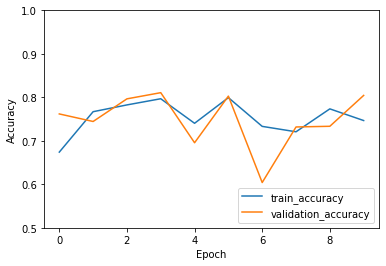

In [ ]:
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

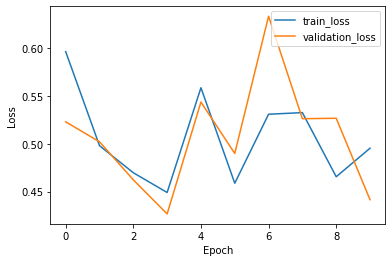

In [ ]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='validation_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
y_pred = model.predict_classes(x_val)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
test_preds = model.predict(x_test)
test_preds = np.round(test_preds)
correct_predictions = float(sum(test_preds == y_test)[0])
print("Correct predictions:", correct_predictions)
print("Total number of test examples:", len(y_test))
print("Accuracy of model1: ", correct_predictions/float(len(y_test)))

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Correct predictions: 515.0
Total number of test examples: 633
Accuracy of model1:  0.8135860979462876


In [ ]:
y_test[1]

array([1., 0.], dtype=float32)

In [ ]:
import numpy as np
rounded_labels=np.argmax(y_test, axis=1)

In [ ]:
rounded_labels

array([1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,

In [ ]:
from sklearn.metrics import classification_report
y_pred = model.predict_classes(x_test)

In [ ]:
print(classification_report(rounded_labels, y_pred, target_names=['negative','positive']))

              precision    recall  f1-score   support

    negative       0.81      0.84      0.82       336
    positive       0.81      0.77      0.79       297

    accuracy                           0.81       633
   macro avg       0.81      0.81      0.81       633
weighted avg       0.81      0.81      0.81       633

